n_inputs: number of input dimensions
n_outputs: numberr of output dimensions
n_reservoir: number of reservoir neurons
random_state: seed for the random generator
sparsity: proportion of recurrent weights set to zero
spectral_radius: spectral radius of the recurrent weight matrix
noise: noise added to each neuron (regularization)

## Install pyESN
Found on GitHub: https://github.com/cknd/pyESN/blob/master/mackey.ipynb


In [1]:
import numpy as np


def correct_dimensions(s, targetlength):
    """checks the dimensionality of some numeric argument s, broadcasts it
       to the specified length if possible.

    Args:
        s: None, scalar or 1D array
        targetlength: expected length of s

    Returns:
        None if s is None, else numpy vector of length targetlength
    """
    if s is not None:
        s = np.array(s)
        if s.ndim == 0:
            s = np.array([s] * targetlength)
        elif s.ndim == 1:
            if not len(s) == targetlength:
                raise ValueError("arg must have length " + str(targetlength))
        else:
            raise ValueError("Invalid argument")
    return s


def identity(x):
    return x


class ESN():

    def __init__(self, n_inputs, n_outputs, n_reservoir=200,
                 spectral_radius=0.95, sparsity=0, noise=0.001, input_shift=None,
                 input_scaling=None, teacher_forcing=True, feedback_scaling=None,
                 teacher_scaling=None, teacher_shift=None,
                 out_activation=identity, inverse_out_activation=identity,
                 random_state=None, silent=True):
        """
        Args:
            n_inputs: nr of input dimensions
            n_outputs: nr of output dimensions
            n_reservoir: nr of reservoir neurons
            spectral_radius: spectral radius of the recurrent weight matrix
            sparsity: proportion of recurrent weights set to zero
            noise: noise added to each neuron (regularization)
            input_shift: scalar or vector of length n_inputs to add to each
                        input dimension before feeding it to the network.
            input_scaling: scalar or vector of length n_inputs to multiply
                        with each input dimension before feeding it to the netw.
            teacher_forcing: if True, feed the target back into output units
            teacher_scaling: factor applied to the target signal
            teacher_shift: additive term applied to the target signal
            out_activation: output activation function (applied to the readout)
            inverse_out_activation: inverse of the output activation function
            random_state: positive integer seed, np.rand.RandomState object,
                          or None to use numpy's builting RandomState.
            silent: supress messages
        """
        # check for proper dimensionality of all arguments and write them down.
        self.n_inputs = n_inputs
        self.n_reservoir = n_reservoir
        self.n_outputs = n_outputs
        self.spectral_radius = spectral_radius
        self.sparsity = sparsity
        self.noise = noise
        self.input_shift = correct_dimensions(input_shift, n_inputs)
        self.input_scaling = correct_dimensions(input_scaling, n_inputs)

        self.teacher_scaling = teacher_scaling
        self.teacher_shift = teacher_shift

        self.out_activation = out_activation
        self.inverse_out_activation = inverse_out_activation
        self.random_state = random_state

        # the given random_state might be either an actual RandomState object,
        # a seed or None (in which case we use numpy's builtin RandomState)
        if isinstance(random_state, np.random.RandomState):
            self.random_state_ = random_state
        elif random_state:
            try:
                self.random_state_ = np.random.RandomState(random_state)
            except TypeError as e:
                raise Exception("Invalid seed: " + str(e))
        else:
            self.random_state_ = np.random.mtrand._rand

        self.teacher_forcing = teacher_forcing
        self.silent = silent
        self.initweights()

    def initweights(self):
        # initialize recurrent weights:
        # begin with a random matrix centered around zero:
        W = self.random_state_.rand(self.n_reservoir, self.n_reservoir) - 0.5
        # delete the fraction of connections given by (self.sparsity):
        W[self.random_state_.rand(*W.shape) < self.sparsity] = 0
        # compute the spectral radius of these weights:
        radius = np.max(np.abs(np.linalg.eigvals(W)))
        # rescale them to reach the requested spectral radius:
        self.W = W * (self.spectral_radius / radius)

        # random input weights:
        self.W_in = self.random_state_.rand(
            self.n_reservoir, self.n_inputs) * 2 - 1
        # random feedback (teacher forcing) weights:
        self.W_feedb = self.random_state_.rand(
            self.n_reservoir, self.n_outputs) * 2 - 1

    def _update(self, state, input_pattern, output_pattern):
        """performs one update step.

        i.e., computes the next network state by applying the recurrent weights
        to the last state & and feeding in the current input and output patterns
        """
        if self.teacher_forcing:
            preactivation = (np.dot(self.W, state)
                             + np.dot(self.W_in, input_pattern)
                             + np.dot(self.W_feedb, output_pattern))
        else:
            preactivation = (np.dot(self.W, state)
                             + np.dot(self.W_in, input_pattern))
        return (np.tanh(preactivation)
                + self.noise * (self.random_state_.rand(self.n_reservoir) - 0.5))

    def _scale_inputs(self, inputs):
        """for each input dimension j: multiplies by the j'th entry in the
        input_scaling argument, then adds the j'th entry of the input_shift
        argument."""
        if self.input_scaling is not None:
            inputs = np.dot(inputs, np.diag(self.input_scaling))
        if self.input_shift is not None:
            inputs = inputs + self.input_shift
        return inputs

    def _scale_teacher(self, teacher):
        """multiplies the teacher/target signal by the teacher_scaling argument,
        then adds the teacher_shift argument to it."""
        if self.teacher_scaling is not None:
            teacher = teacher * self.teacher_scaling
        if self.teacher_shift is not None:
            teacher = teacher + self.teacher_shift
        return teacher

    def _unscale_teacher(self, teacher_scaled):
        """inverse operation of the _scale_teacher method."""
        if self.teacher_shift is not None:
            teacher_scaled = teacher_scaled - self.teacher_shift
        if self.teacher_scaling is not None:
            teacher_scaled = teacher_scaled / self.teacher_scaling
        return teacher_scaled

    def fit(self, inputs, outputs, inspect=False):
        """
        Collect the network's reaction to training data, train readout weights.

        Args:
            inputs: array of dimensions (N_training_samples x n_inputs)
            outputs: array of dimension (N_training_samples x n_outputs)
            inspect: show a visualisation of the collected reservoir states

        Returns:
            the network's output on the training data, using the trained weights
        """
        # transform any vectors of shape (x,) into vectors of shape (x,1):
        if inputs.ndim < 2:
            inputs = np.reshape(inputs, (len(inputs), -1))
        if outputs.ndim < 2:
            outputs = np.reshape(outputs, (len(outputs), -1))
        # transform input and teacher signal:
        inputs_scaled = self._scale_inputs(inputs)
        teachers_scaled = self._scale_teacher(outputs)

        if not self.silent:
            print("harvesting states...")
        # step the reservoir through the given input,output pairs:
        states = np.zeros((inputs.shape[0], self.n_reservoir))
        for n in range(1, inputs.shape[0]):
            states[n, :] = self._update(states[n - 1], inputs_scaled[n, :],
                                        teachers_scaled[n - 1, :])

        # learn the weights, i.e. find the linear combination of collected
        # network states that is closest to the target output
        if not self.silent:
            print("fitting...")
        # we'll disregard the first few states:
        transient = min(int(inputs.shape[1] / 10), 100)
        # include the raw inputs:
        extended_states = np.hstack((states, inputs_scaled))
        # Solve for W_out:
        self.W_out = np.dot(np.linalg.pinv(extended_states[transient:, :]),
                            self.inverse_out_activation(teachers_scaled[transient:, :])).T

        # remember the last state for later:
        self.laststate = states[-1, :]
        self.lastinput = inputs[-1, :]
        self.lastoutput = teachers_scaled[-1, :]

        # optionally visualize the collected states
        if inspect:
            from matplotlib import pyplot as plt
            # (^-- we depend on matplotlib only if this option is used)
            plt.figure(
                figsize=(states.shape[0] * 0.0025, states.shape[1] * 0.01))
            plt.imshow(extended_states.T, aspect='auto',
                       interpolation='nearest')
            plt.colorbar()

        if not self.silent:
            print("training error:")
        # apply learned weights to the collected states:
        pred_train = self._unscale_teacher(self.out_activation(
            np.dot(extended_states, self.W_out.T)))
        if not self.silent:
            print(np.sqrt(np.mean((pred_train - outputs)**2)))
        return pred_train

    def predict(self, inputs, continuation=True):
        """
        Apply the learned weights to the network's reactions to new input.

        Args:
            inputs: array of dimensions (N_test_samples x n_inputs)
            continuation: if True, start the network from the last training state

        Returns:
            Array of output activations
        """
        if inputs.ndim < 2:
            inputs = np.reshape(inputs, (len(inputs), -1))
        n_samples = inputs.shape[0]

        if continuation:
            laststate = self.laststate
            lastinput = self.lastinput
            lastoutput = self.lastoutput
        else:
            laststate = np.zeros(self.n_reservoir)
            lastinput = np.zeros(self.n_inputs)
            lastoutput = np.zeros(self.n_outputs)

        inputs = np.vstack([lastinput, self._scale_inputs(inputs)])
        states = np.vstack(
            [laststate, np.zeros((n_samples, self.n_reservoir))])
        outputs = np.vstack(
            [lastoutput, np.zeros((n_samples, self.n_outputs))])

        for n in range(n_samples):
            states[
                n + 1, :] = self._update(states[n, :], inputs[n + 1, :], outputs[n, :])
            outputs[n + 1, :] = self.out_activation(np.dot(self.W_out,
                                                           np.concatenate([states[n + 1, :], inputs[n + 1, :]])))

        return self._unscale_teacher(self.out_activation(outputs[1:]))

## Load libraries

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# This is the library for the Reservoir Computing got it by: https://github.com/cknd/pyESN
#from pyESN import ESN 
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
import pandas_datareader as pdr
import datetime
import math
import numpy as np

import seaborn as sns
from matplotlib import rc
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=False)

In [4]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

%cd /content/drive/My Drive/Thesis/Thesissub/

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/Thesis/Thesissub


# Import Data - start

## Set

In [75]:
data = pd.read_csv('cleaned_BTC.csv')
data = data.loc[:, ~data.columns.str.contains('^Unnamed')]
data = data.reset_index()
df = data[['close']]
df = np.array(df).astype('float64')

In [76]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()

df =scaler.fit_transform(df)

In [88]:
n_reservoir= 1000
sparsity=0.4
rand_seed=23
spectral_radius = 1.5
noise = .0007

trainlen = 1500
future = 1
futureTotal=100


In [89]:
esn = ESN(n_inputs = 1,
      n_outputs = 1, 
      n_reservoir = n_reservoir,
      sparsity=sparsity,
      random_state=rand_seed,
      spectral_radius = spectral_radius,
      noise=noise)

In [90]:
pred_tot=np.zeros(futureTotal)

for i in range(0,futureTotal,future):
    pred_training = esn.fit(np.ones(trainlen),df[i:trainlen+i])
    prediction = esn.predict(np.ones(future))
    pred_tot[i:i+future] = prediction[:,0]

In [91]:
def MSE(yhat, y):
    return np.sqrt(np.mean((yhat.flatten() - y)**2))

from sklearn.metrics import r2_score, accuracy_score

In [92]:
loss_k_5 = MSE(pred_tot, df[trainlen:trainlen+futureTotal])
loss_k_5

0.20751968602695228

In [93]:
r2_score(pred_tot, df[trainlen:trainlen+futureTotal])

0.66943020281736

### Visualize

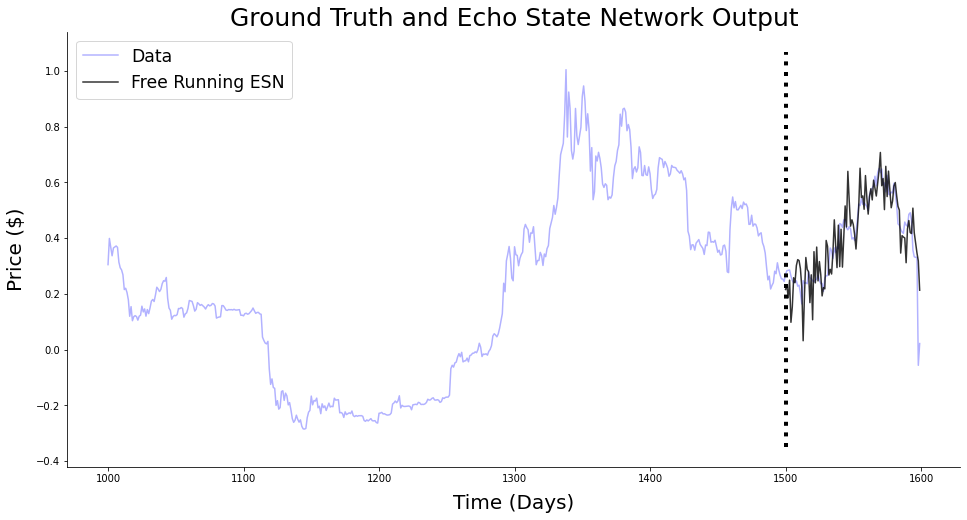

In [94]:
plt.figure(figsize=(16,8))
plt.plot(range(1000,trainlen+futureTotal),df[1000:trainlen+futureTotal],'b',label="Data", alpha=0.3)
#plt.plot(range(0,trainlen),pred_training,'.g',  alpha=0.3)
plt.plot(range(trainlen,trainlen+futureTotal),pred_tot,'k',  alpha=0.8, label='Free Running ESN')

lo,hi = plt.ylim()
plt.plot([trainlen,trainlen],[lo+np.spacing(1),hi-np.spacing(1)],'k:', linewidth=4)

plt.title(r'Ground Truth and Echo State Network Output', fontsize=25)
plt.xlabel(r'Time (Days)', fontsize=20,labelpad=10)
plt.ylabel(r'Price ($)', fontsize=20,labelpad=10)
plt.legend(fontsize='xx-large', loc='best')
sns.despine()

## Optimize hyper-parameters

In [ ]:
loss_k_5 = MSE(pred_tot, data[trainlen:trainlen+futureTotal])
loss_k_5

1687.110130649506

In [78]:

n_reservoir= 500
sparsity   = 0.2
rand_seed  = 23
radius_set = [0.9,  1,  1.1]
noise_set = [ 0.001, 0.004, 0.006]

radius_set = [0.5, 0.7, 0.9,  1,  1.1,1.3,1.5]
noise_set = [ 0.0001, 0.0003,0.0007, 0.001, 0.003, 0.005, 0.007,0.01]



radius_set_size  = len(radius_set)
noise_set_size = len(noise_set)

trainlen = 1500
future = 2
futureTotal= 100

loss = np.zeros([radius_set_size, noise_set_size])
score = np.zeros([radius_set_size, noise_set_size])
for l in range(radius_set_size):
    rho = radius_set[l]
    for j in range(noise_set_size):
        noise = noise_set[j]

        pred_tot=np.zeros(futureTotal)

        esn = ESN(n_inputs = 1,
          n_outputs = 1, 
          n_reservoir = n_reservoir,
          sparsity=sparsity,
          random_state=rand_seed,
          spectral_radius = rho,
          noise=noise)

        for i in range(0,futureTotal,future):
            pred_training = esn.fit(np.ones(trainlen),df[i:trainlen+i])
            prediction = esn.predict(np.ones(future))
            pred_tot[i:i+future] = prediction[:,0]
        
        loss[l, j] = MSE(pred_tot, df[trainlen:trainlen+futureTotal]) 
        score[l,j] = r2_score(pred_tot, df[trainlen:trainlen+futureTotal])       
        print('rho = ', radius_set[l], ', noise = ', noise_set[j], ', MSE = ', loss[l][j] , 'Score =', score[l,j])


rho =  0.5 , noise =  0.0001 , MSE =  0.19751779660135024 Score = 0.7261821215860447
rho =  0.5 , noise =  0.0003 , MSE =  0.19573031388499568 Score = 0.697097933958198
rho =  0.5 , noise =  0.0007 , MSE =  0.19502547559656427 Score = 0.6891983698564259
rho =  0.5 , noise =  0.001 , MSE =  0.19493207370918403 Score = 0.6871078999860718
rho =  0.5 , noise =  0.003 , MSE =  0.19570941691348248 Score = 0.6890538532316063
rho =  0.5 , noise =  0.005 , MSE =  0.19600597475403828 Score = 0.6909952653210383
rho =  0.5 , noise =  0.007 , MSE =  0.19608869687490274 Score = 0.690988137231968
rho =  0.5 , noise =  0.01 , MSE =  0.19617256142455033 Score = 0.6912271850586075
rho =  0.7 , noise =  0.0001 , MSE =  0.1980743858183342 Score = 0.7712361620926154
rho =  0.7 , noise =  0.0003 , MSE =  0.19610336622983246 Score = 0.7604626052578487
rho =  0.7 , noise =  0.0007 , MSE =  0.19501007971022727 Score = 0.7358953034613185
rho =  0.7 , noise =  0.001 , MSE =  0.194621514557269 Score = 0.725344371

In [79]:
minLoss = np.min(loss)
index_min = np.where(loss == minLoss)
index_min
rho_opt = radius_set[int(index_min[0])]
noise_opt = noise_set[int(index_min[1])]
print('The optimal set is:\nspectrum radius = ',
      rho_opt,'\nnoise = ',noise_opt,'\nMSE = ',minLoss)

The optimal set is:
spectrum radius =  1.5 
noise =  0.007 
MSE =  0.19350883367471988


In [80]:
maxScore = np.max(score)
index_max = np.where(score == maxScore)
index_max
rho_opt = radius_set[int(index_min[0])]
noise_opt = noise_set[int(index_min[1])]
print('The optimal set is:\nspectrum radius = ',
      rho_opt,'\nnoise = ',noise_opt,'\nMSE = ',loss, '\nScore =', maxScore)

The optimal set is:
spectrum radius =  1.5 
noise =  0.007 
MSE =  [[0.1975178  0.19573031 0.19502548 0.19493207 0.19570942 0.19600597
  0.1960887  0.19617256]
 [0.19807439 0.19610337 0.19501008 0.19462151 0.19400414 0.19434592
  0.19471169 0.1951226 ]
 [0.20177661 0.20019297 0.19731631 0.19633799 0.19478953 0.19454792
  0.19448203 0.19452406]
 [0.20042228 0.19979539 0.19945832 0.19854487 0.19531881 0.19467721
  0.19461583 0.19475381]
 [0.20180728 0.20087897 0.19973675 0.199396   0.19801355 0.197017
  0.1964903  0.19621387]
 [0.20065056 0.19869238 0.19696919 0.19651285 0.19640502 0.19665652
  0.19680432 0.1969771 ]
 [0.19608672 0.19599381 0.19573437 0.19551463 0.19418521 0.19357377
  0.19350883 0.19369737]] 
Score = 0.7712361620926154


### Testing 30 days 

In [52]:
n_reservoir= 500
sparsity_set   =  0.8
rand_seed  = 23


radius_set = [0.5, 0.7, 0.9,  1,  1.1,1.3,1.5]
noise_set = [ 0.0001, 0.0003,0.0007, 0.001, 0.003]


radius_set_size  = len(radius_set)
noise_set_size = len(noise_set)

trainlen = 1200
future = 30
futureTotal= 120

loss = np.zeros([radius_set_size, noise_set_size])

for l in range(radius_set_size):
    rho = radius_set[l]
    for j in range(noise_set_size):
        noise = noise_set[j]


        pred_tot=np.zeros(futureTotal)

        esn = ESN(n_inputs = 1,
          n_outputs = 1, 
          n_reservoir = n_reservoir,
          sparsity=sparsity,
          random_state=rand_seed,
          spectral_radius = rho,
          noise=noise)

        for i in range(0,futureTotal,future):
            pred_training = esn.fit(np.ones(trainlen),data[i:trainlen+i])
            prediction = esn.predict(np.ones(future))
            pred_tot[i:i+future] = prediction[:,0]

        loss[l, j] = MSE(pred_tot, data[trainlen:trainlen+futureTotal])        
        print('rho = ', radius_set[l], ', noise = ', noise_set[j], ', MSE = ', loss[l][j])

TypeError: ignored

In [ ]:
minLoss = np.min(loss)
index_min = np.where(loss == minLoss)
index_min
rho_opt = radius_set[int(index_min[0])]
noise_opt = noise_set[int(index_min[1])]
print('The optimal set is:\nspectrum radius = ',
      rho_opt,'\nnoise = ',noise_opt,'\nMSE = ',minLoss)

The optimal set is:
spectrum radius =  1.5 
noise =  0.0001 
MSE =  2998.5273797477885


# Correlation matrix

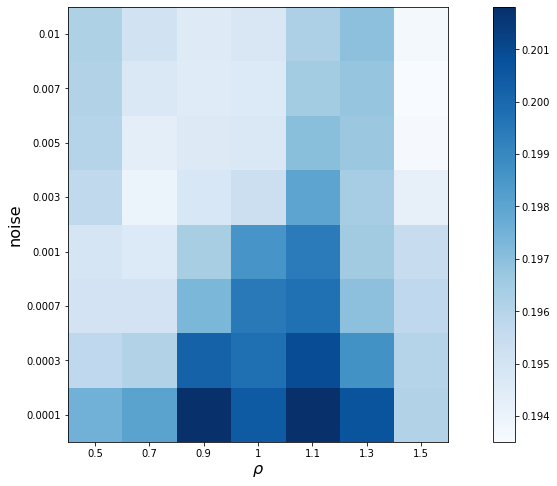

In [81]:
plt.figure(figsize=(16,8))
im = plt.imshow(loss.T, vmin=abs(loss).min(), vmax=abs(loss).max(), origin='lower',cmap='Blues')
plt.xticks(np.linspace(0,radius_set_size-1,radius_set_size), radius_set);
plt.yticks(np.linspace(0,noise_set_size-1, noise_set_size), noise_set);
plt.xlabel(r'$\rho$', fontsize=16); plt.ylabel('noise', fontsize=16); 

# im.set_interpolation('bilinear')
cb = plt.colorbar(im);

## Explore ability for longer predictions

Can RC predict 1, 5, 10 and 30 day to a degree of accuracy?


In [84]:
n_reservoir= 1000
sparsity=0.4
rand_seed=23
spectral_radius = 1.5
noise = 0.007

# let k_set be an array with the prediction-window values
k_set = [1,5,30]

k_size = len(k_set)
loss_k = np.zeros(k_size)
score_k = np.zeros(k_size)
for l in range(k_size):
    future = k_set[l]

    trainlen = 1500    
    futureTotal=120
    
    pred_tot=np.zeros(futureTotal)

    esn = ESN(n_inputs = 1,
          n_outputs = 1, 
          n_reservoir = n_reservoir,
          sparsity=sparsity,
          random_state=rand_seed,
          spectral_radius = spectral_radius,
          noise=noise)


    for i in range(0,futureTotal,future):
        pred_training = esn.fit(np.ones(trainlen),df[i:trainlen+i])
        prediction = esn.predict(np.ones(future))
        pred_tot[i:i+future] = prediction[:,0]
        
    loss_k[l] = MSE(pred_tot, df[trainlen:trainlen+futureTotal])
    score_k[l] = r2_score(pred_tot, df[trainlen:trainlen+futureTotal])

In [85]:
print('set = ',
      k_set,'\loss = ',loss_k, '\score=', score_k)

set =  [1, 5, 30] \loss =  [0.26925471 0.29350384 0.71821917] \score= [ 0.77798321  0.27659641 -0.17163715]


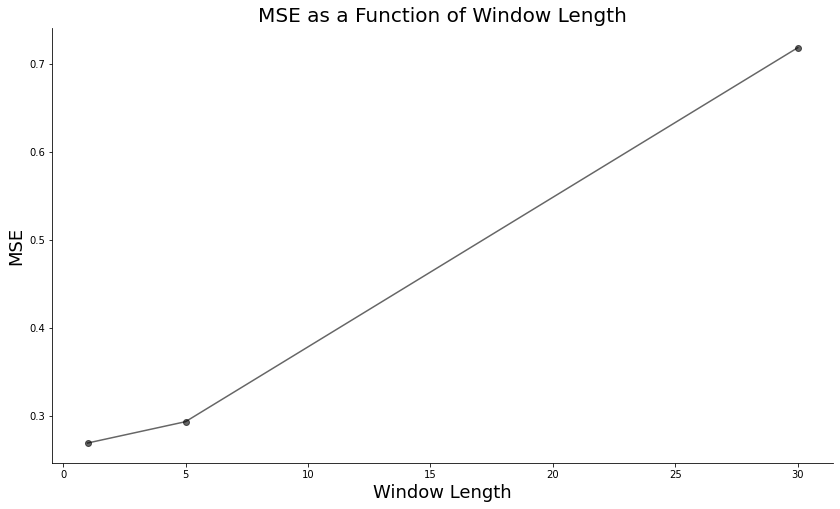

In [87]:
plt.figure(figsize=(14,8))
plt.plot(k_set, loss_k,'-ok', alpha=0.6)
plt.title('MSE as a Function of Window Length', fontsize=20)
plt.xlabel('Window Length', fontsize=18)
plt.ylabel('MSE', fontsize=18)
sns.despine()

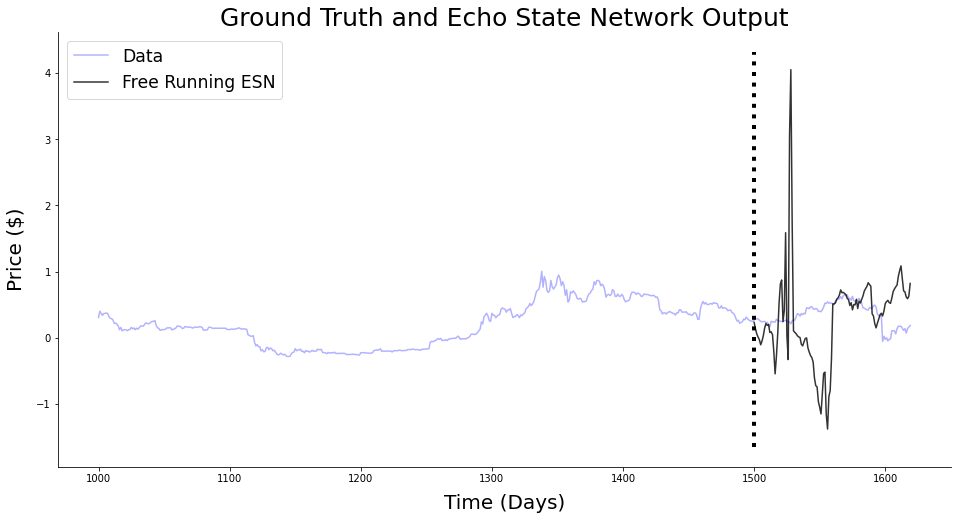

In [86]:
plt.figure(figsize=(16,8))
plt.plot(range(1000,trainlen+futureTotal),df[1000:trainlen+futureTotal],'b',label="Data", alpha=0.3)
#plt.plot(range(0,trainlen),pred_training,'.g',  alpha=0.3)
plt.plot(range(trainlen,trainlen+futureTotal),pred_tot,'k',  alpha=0.8, label='Free Running ESN')

lo,hi = plt.ylim()
plt.plot([trainlen,trainlen],[lo+np.spacing(1),hi-np.spacing(1)],'k:', linewidth=4)

plt.title(r'Ground Truth and Echo State Network Output', fontsize=25)
plt.xlabel(r'Time (Days)', fontsize=20,labelpad=10)
plt.ylabel(r'Price ($)', fontsize=20,labelpad=10)
plt.legend(fontsize='xx-large', loc='best')
sns.despine()

## After hyperparameterization

The optimal set is:
spectrum radius =  0.7 
noise =  0.0003 
MSE =  1365.5557624076646

In [ ]:
n_reservoir= 1000
sparsity=0.4
rand_seed=23
spectral_radius = rho_opt
noise = noise_opt


In [ ]:
esn = ESN(n_inputs = 1,
      n_outputs = 1, 
      n_reservoir = n_reservoir,
      sparsity=sparsity,
      random_state=rand_seed,
      spectral_radius = spectral_radius,
      noise=noise)

In [ ]:
trainlen = 1500
future = 5
futureTotal=100


In [ ]:
pred_tot=np.zeros(futureTotal)
for i in range(0,futureTotal,future):
    pred_training = esn.fit(np.ones(trainlen),data[i:trainlen+i])
    prediction = esn.predict(np.ones(future))
    pred_tot[i:i+future] = prediction[:,0]

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(range(1000,trainlen+futureTotal),data[1000:trainlen+futureTotal],'b',label="Data", alpha=0.3)
#plt.plot(range(0,trainlen),pred_training,'.g',  alpha=0.3)
plt.plot(range(trainlen,trainlen+futureTotal),pred_tot,'k',  alpha=0.8, label='Free Running ESN')

lo,hi = plt.ylim()
plt.plot([trainlen,trainlen],[lo+np.spacing(1),hi-np.spacing(1)],'k:', linewidth=4)

plt.title(r'Ground Truth and Echo State Network Output', fontsize=25)
plt.xlabel(r'Time (Days)', fontsize=20,labelpad=10)
plt.ylabel(r'Price ($)', fontsize=20,labelpad=10)
plt.legend(fontsize='xx-large', loc='best')
sns.despine()